<h1>Model Prediksi Penyakit Kulit di Wajah</h1>

## Penjelasan Project: Model Prediksi Penyakit Kulit di Wajah

Project ini bertujuan untuk membangun model deep learning yang dapat mengklasifikasikan kondisi kulit wajah berdasarkan gambar menjadi beberapa kategori, seperti Acne, Blackheads, Dark Spots, Normal Skin, Oily Skin, dan Wrinkles. Berikut penjelasan detail alur kerja project:

### 1. **Persiapan Dataset**
Dataset berisi gambar wajah yang telah dikategorikan ke dalam folder sesuai labelnya. Setiap gambar akan diproses dan diubah ukurannya agar seragam sebelum digunakan untuk training.

### 2. **Preprocessing & Augmentasi**
Menggunakan `ImageDataGenerator` dari Keras untuk melakukan augmentasi data (rotasi, flip, zoom, dsb) agar model lebih robust terhadap variasi gambar. Data juga dibagi menjadi data training dan validasi.

### 3. **Transfer Learning**
Model menggunakan arsitektur MobileNetV2 yang sudah dilatih pada dataset ImageNet. Bagian feature extractor dari MobileNetV2 digunakan, lalu ditambahkan beberapa layer dense untuk klasifikasi sesuai jumlah kategori kulit.

### 4. **Training Model**
Model dilatih menggunakan data training, dengan callback seperti EarlyStopping, ModelCheckpoint, dan ReduceLROnPlateau untuk menghindari overfitting dan mengoptimalkan proses training. Class weight juga dihitung untuk mengatasi ketidakseimbangan jumlah data antar kelas.

### 5. **Fine-tuning**
Setelah training awal, beberapa layer dari base model MobileNetV2 dibuka (unfreeze) untuk fine-tuning, sehingga model dapat belajar fitur yang lebih spesifik dari dataset kulit wajah.

### 6. **Evaluasi**
Model dievaluasi menggunakan confusion matrix dan classification report untuk melihat performa pada data validasi. Visualisasi training juga dilakukan untuk memantau akurasi dan loss.

### 7. **Prediksi Gambar Baru**
Disediakan fungsi untuk memprediksi kondisi kulit dari gambar baru. Hasil prediksi juga disertai confidence score dan rekomendasi produk skincare yang sesuai dengan kondisi kulit yang terdeteksi.

### 8. **Ekspor Model**
Model yang sudah dilatih diekspor ke format H5 (Keras) dan ONNX agar dapat digunakan di berbagai platform.

---

**Manfaat Project:**
- Membantu pengguna mengenali kondisi kulit wajah secara otomatis dari gambar.
- Memberikan rekomendasi produk skincare yang relevan.
- Dapat dikembangkan lebih lanjut untuk aplikasi mobile atau web.

Project ini menggabungkan teknik computer vision, transfer learning, dan data augmentation untuk menghasilkan model klasifikasi kulit wajah yang akurat dan praktis digunakan.

<h1># 1. Import Library</h1>

### Penjelasan Tahapan Import Library

Pada tahap ini, dilakukan import berbagai library yang dibutuhkan untuk membangun model prediksi penyakit kulit wajah. Berikut penjelasan fungsi masing-masing library:

- **os**: Untuk operasi terkait sistem file, seperti pengecekan keberadaan file atau folder.
- **numpy**: Library utama untuk komputasi numerik dan manipulasi array.
- **pandas**: Digunakan untuk manipulasi dan analisis data berbasis tabel (dataframe), misal membaca file CSV rekomendasi produk.
- **matplotlib.pyplot** dan **seaborn**: Untuk visualisasi data, seperti plotting distribusi data, training history, dan confusion matrix.
- **tensorflow**: Framework utama untuk deep learning, digunakan untuk membangun, melatih, dan menyimpan model.
- **tensorflow.keras.preprocessing.image.ImageDataGenerator**: Untuk augmentasi dan preprocessing gambar secara otomatis saat training.
- **tensorflow.keras.applications.mobilenet_v2.preprocess_input**: Fungsi preprocessing khusus untuk arsitektur MobileNetV2.
- **tensorflow.keras.applications.MobileNetV2**: Model deep learning pretrained yang digunakan sebagai feature extractor (transfer learning).
- **tensorflow.keras.layers**: Berisi layer-layer neural network seperti GlobalAveragePooling2D, Dense, Dropout, dan Input.
- **tensorflow.keras.models.Model**: Untuk membangun model custom dengan arsitektur yang diinginkan.
- **tensorflow.keras.callbacks**: Callback seperti EarlyStopping, ModelCheckpoint, dan ReduceLROnPlateau untuk mengontrol proses training.
- **sklearn.utils.class_weight.compute_class_weight**: Untuk menghitung bobot kelas jika data tidak seimbang.
- **sklearn.metrics**: Untuk evaluasi model, seperti confusion matrix dan classification report.

Dengan mengimpor library di atas, seluruh kebutuhan mulai dari data handling, preprocessing, pembuatan model, training, evaluasi, hingga visualisasi dapat dilakukan secara terintegrasi.

In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import glob


<h1>Menyiapkan Path Dataset dan Label</h1>

## Penjelasan Detail: Parameter dan Path

Pada bagian **Parameter dan Path**, beberapa variabel penting didefinisikan sebelum proses data dan training model dilakukan. Berikut penjelasan kegunaan setiap parameter:

- **dataset_path**: Menyimpan lokasi folder dataset utama yang berisi gambar-gambar wajah yang sudah dikelompokkan berdasarkan kategori (label). Path ini akan digunakan oleh ImageDataGenerator untuk membaca data secara otomatis sesuai struktur folder.

- **categories**: List berisi nama-nama kelas/label yang akan diprediksi oleh model, seperti 'Acne', 'Blackheads', 'Dark Spots', 'Normal Skin', 'Oily Skin', dan 'Wrinkles'. Daftar ini penting untuk mapping label numerik ke nama kelas saat training, evaluasi, dan prediksi.

- **img_size**: Ukuran gambar (dalam piksel) yang akan digunakan sebagai input model. Semua gambar akan di-resize ke ukuran ini agar seragam dan sesuai dengan arsitektur model (MobileNetV2 membutuhkan input 224x224 piksel).

- **BATCH_SIZE**: Jumlah gambar yang diproses dalam satu batch saat training. Batch size mempengaruhi kecepatan training dan penggunaan memori GPU/CPU.

- **num_classes**: Jumlah total kelas yang akan diprediksi model, diambil dari panjang list categories. Nilai ini digunakan untuk menentukan jumlah neuron pada output layer model.

### Kegunaan Tahapan Ini

Tahapan inisialisasi parameter dan path sangat penting karena:

- **Memastikan seluruh pipeline konsisten**: Semua proses (preprocessing, training, evaluasi, prediksi) menggunakan parameter yang sama, sehingga hasil lebih valid dan mudah direproduksi.
- **Memudahkan modifikasi**: Jika ingin mengganti dataset, menambah kelas, atau mengubah ukuran gambar, cukup mengubah parameter di satu tempat.
- **Mengurangi error**: Dengan mendefinisikan parameter di awal, risiko typo atau inkonsistensi antar bagian kode dapat diminimalisir.
- **Mendukung otomatisasi**: Parameter yang jelas dan terstruktur memudahkan pengembangan lebih lanjut, seperti otomatisasi training atau deployment model.

Secara keseluruhan, bagian ini adalah fondasi awal agar workflow machine learning berjalan terstruktur, efisien, dan mudah dikembangkan.

In [2]:
dataset_path = 'dataset'
categories = ['Acne', 'Blackheads', 'Dark Spots', 'Normal Skin', 'Oily Skin', 'Wrinkles']
img_size = 224
BATCH_SIZE = 64
num_classes = len(categories)

<h1>Data Generator & Preprocessing</h1>

## Penjelasan Detail: Data Generator & Preprocessing

Pada tahap **Data Generator & Preprocessing**, dilakukan serangkaian proses untuk menyiapkan data gambar sebelum digunakan dalam pelatihan model deep learning. Berikut penjelasan detail setiap langkah yang dilakukan:

### 1. **ImageDataGenerator**
Digunakan `ImageDataGenerator` dari Keras untuk melakukan augmentasi dan preprocessing gambar secara otomatis. Parameter yang digunakan antara lain:
- `preprocessing_function=preprocess_input`: Fungsi preprocessing khusus untuk arsitektur MobileNetV2, seperti normalisasi pixel sesuai standar model pretrained.
- `validation_split=0.2`: Membagi dataset menjadi 80% data training dan 20% data validasi secara otomatis.
- `rotation_range=20`: Melakukan rotasi acak pada gambar hingga 20 derajat untuk meningkatkan variasi data.
- `width_shift_range` dan `height_shift_range=0.2`: Menggeser gambar secara horizontal dan vertikal hingga 20% dari ukuran gambar.
- `horizontal_flip=True`: Melakukan flip horizontal secara acak untuk memperkaya data.
- `brightness_range=[0.8, 1.2]`: Mengubah tingkat kecerahan gambar secara acak.
- `shear_range=0.2`: Melakukan transformasi shear pada gambar.
- `zoom_range=0.2`: Melakukan zoom in/out secara acak pada gambar.

Augmentasi ini bertujuan untuk membuat model lebih robust terhadap variasi gambar di dunia nyata dan mengurangi risiko overfitting.

### 2. **flow_from_directory**
Metode `flow_from_directory` digunakan untuk membaca gambar langsung dari struktur folder dataset:
- `target_size=(img_size, img_size)`: Semua gambar diubah ukurannya menjadi 224x224 piksel agar seragam dan sesuai dengan input model.
- `batch_size=BATCH_SIZE`: Menentukan jumlah gambar yang diproses dalam satu batch.
- `class_mode='sparse'`: Label dikonversi menjadi integer, cocok untuk klasifikasi multi-kelas.
- `subset='training'` dan `subset='validation'`: Memisahkan data training dan validasi berdasarkan split yang telah ditentukan.
- `shuffle=True` pada training untuk mengacak urutan data, sedangkan pada validasi `shuffle=False` agar evaluasi lebih konsisten.

### 3. **Manfaat Tahapan Ini**
- **Meningkatkan Generalisasi Model**: Augmentasi membuat model belajar dari variasi data yang lebih luas.
- **Preprocessing Otomatis**: Semua gambar diproses secara konsisten sesuai kebutuhan arsitektur model.
- **Efisiensi**: Data generator memproses gambar secara real-time dalam batch, sehingga menghemat memori dan mempercepat training.
- **Pembagian Data yang Konsisten**: Dengan `validation_split`, pembagian data training dan validasi dilakukan secara otomatis dan reproducible.

Tahapan ini sangat penting sebagai fondasi sebelum data masuk ke proses pelatihan model, memastikan kualitas dan keragaman data yang optimal untuk menghasilkan model yang akurat dan andal.

In [3]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    zoom_range=0.2
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

Found 1920 images belonging to 6 classes.
Found 480 images belonging to 6 classes.


Output tersebut berasal dari proses inisialisasi data generator menggunakan `flow_from_directory` pada Keras. Berikut penjelasannya:

- **Found 1920 images belonging to 6 classes.**  
    Artinya, pada data training, terdapat total 1920 gambar yang terbagi ke dalam 6 kelas (kategori kulit wajah: Acne, Blackheads, Dark Spots, Normal Skin, Oily Skin, Wrinkles). Data ini digunakan untuk melatih model.

- **Found 480 images belonging to 6 classes.**  
    Pada data validasi, terdapat 480 gambar yang juga terbagi ke dalam 6 kelas yang sama. Data ini digunakan untuk mengevaluasi performa model selama proses training.

Pembagian ini sesuai dengan parameter `validation_split=0.2`, sehingga sekitar 80% data digunakan untuk training dan 20% untuk validasi. Struktur folder dataset sudah terbaca dengan benar oleh data generator, dan seluruh kelas terdeteksi sesuai harapan.

<h1>Cek Mapping Label dan Distribusi Data</h1>

## Penjelasan Detail: Cek Mapping Label dan Distribusi Data

Pada tahap **Cek Mapping Label dan Distribusi Data**, dilakukan pemeriksaan terhadap hasil pemetaan folder dataset ke label numerik (class indices) serta distribusi jumlah data pada masing-masing kelas. Berikut penjelasan detail setiap langkahnya:

### 1. **Mapping Label (class_indices)**
- `class_indices` merupakan dictionary yang menunjukkan pemetaan antara nama folder (label kelas) dengan angka (label numerik) yang digunakan model selama training.
- Pemetaan ini penting untuk memastikan urutan label pada data generator sesuai dengan urutan pada variabel `categories`, sehingga interpretasi hasil prediksi menjadi akurat.

### 2. **Distribusi Data pada Setiap Kelas**
- Distribusi data dihitung menggunakan `np.bincount(train_gen.classes)`, yang menghasilkan jumlah sampel pada masing-masing kelas di data training.
- Pemeriksaan distribusi ini bertujuan untuk mengetahui apakah terdapat ketidakseimbangan (imbalance) antara jumlah data di tiap kelas.

### 3. **Kegunaan Tahapan Ini**
- **Validasi Struktur Dataset:** Memastikan struktur folder dataset sudah benar dan seluruh kelas terdeteksi dengan tepat oleh data generator.
- **Mencegah Kesalahan Label:** Menghindari kesalahan mapping label yang dapat menyebabkan hasil prediksi tidak sesuai dengan kelas sebenarnya.
- **Identifikasi Imbalance Data:** Mengetahui distribusi data sangat penting untuk menentukan perlakuan khusus, seperti penggunaan class weight saat training agar model tidak bias terhadap kelas mayoritas.
- **Dasar Evaluasi Model:** Informasi distribusi label membantu dalam interpretasi hasil evaluasi model, terutama pada metrik seperti confusion matrix dan classification report.

Dengan melakukan pengecekan mapping label dan distribusi data, proses training dan evaluasi model dapat berjalan lebih terkontrol, akurat, serta meminimalisir risiko kesalahan akibat ketidaksesuaian label atau ketidakseimbangan data.

In [4]:
print("Mapping folder ke label (class_indices):", train_gen.class_indices)
print("Urutan categories:", categories)
print("Distribusi label di data training:", np.bincount(train_gen.classes))

Mapping folder ke label (class_indices): {'Acne': 0, 'Blackheads': 1, 'Dark Spots': 2, 'Normal Skin': 3, 'Oily Skin': 4, 'Wrinkles': 5}
Urutan categories: ['Acne', 'Blackheads', 'Dark Spots', 'Normal Skin', 'Oily Skin', 'Wrinkles']
Distribusi label di data training: [320 320 320 320 320 320]


Output mapping label dan distribusi data menunjukkan bahwa setiap folder pada dataset telah dipetakan ke label numerik secara konsisten (misal 'Acne' = 0, 'Wrinkles' = 5), urutan kategori sudah sesuai pipeline, dan distribusi gambar di data training sangat seimbang (masing-masing kelas berisi 320 gambar). Kondisi ini ideal untuk training model klasifikasi karena meminimalkan risiko bias, memastikan interpretasi hasil prediksi akurat, serta memudahkan proses evaluasi dan pengembangan model lebih lanjut.


<h1>Hitung Class Weight guna mengatasi Imbalance (ketidak seimbangan data)</h1>

## Penjelasan Tahapan: Hitung Class Weight untuk Mengatasi Imbalance

Pada tahap **Hitung Class Weight**, dilakukan perhitungan bobot kelas secara otomatis untuk mengatasi ketidakseimbangan jumlah data antar kelas (class imbalance) pada dataset. Ketidakseimbangan ini terjadi ketika jumlah sampel pada satu atau beberapa kelas jauh lebih sedikit dibandingkan kelas lainnya. Jika tidak diatasi, model cenderung bias terhadap kelas mayoritas sehingga performa prediksi pada kelas minoritas menjadi buruk.

Dengan menghitung class weight menggunakan fungsi `compute_class_weight` dari scikit-learn, setiap kelas akan diberikan bobot yang proporsional terhadap kebalikannya dari frekuensi kemunculannya. Kelas yang lebih jarang akan mendapatkan bobot lebih besar, sehingga model akan "memperhatikan" kelas tersebut lebih serius selama proses training.

Penerapan class weight pada training model bertujuan untuk:
- **Mengurangi bias model terhadap kelas mayoritas**
- **Meningkatkan akurasi prediksi pada kelas minoritas**
- **Membantu model belajar secara adil dari seluruh kelas**

Langkah ini sangat penting terutama pada kasus klasifikasi multi-kelas dengan distribusi data yang tidak seimbang, agar model yang dihasilkan lebih robust dan adil dalam melakukan prediksi pada semua kategori.

In [5]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0}


Output di atas menunjukkan bahwa setiap kelas pada dataset memiliki bobot (class weight) yang sama, yaitu 1.0. Artinya, distribusi data pada setiap kelas seimbang (jumlah sampel di tiap kelas hampir sama), sehingga tidak diperlukan penyesuaian bobot khusus saat training. Model akan memperlakukan semua kelas secara adil tanpa bias ke kelas tertentu. Jika terjadi ketidakseimbangan data, nilai class weight akan berbeda dan kelas minoritas akan mendapat bobot lebih besar.

<h1>Membangun Model</h1>

## Penjelasan Detail: Tahapan Membangun Model

Pada tahap **Membangun Model**, dilakukan proses konstruksi arsitektur deep learning berbasis transfer learning menggunakan MobileNetV2 sebagai feature extractor. Berikut penjelasan detail setiap langkah yang dilakukan:
### 1. **Transfer Learning dengan MobileNetV2**
### 2. **Penambahan Layer Kustom**
### 3. **Kompilasi Model**
### 4. **Ringkasan Model**


In [6]:
#Transfer Learning Model (MobileNetV2 + Decision Layer)
base_model = MobileNetV2(
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

Penjelasan tahapan diatas sebagai berikut: <br>
**Transfer Learning dengan MobileNetV2**
- **MobileNetV2** dipilih sebagai backbone karena ringan, cepat, dan sudah terbukti efektif untuk tugas klasifikasi gambar, terutama pada perangkat dengan keterbatasan sumber daya.
- Model diinisialisasi dengan parameter `include_top=False` agar hanya bagian feature extractor yang digunakan, tanpa fully connected layer bawaan.
- Bobot awal (`weights='imagenet'`) diambil dari hasil training pada dataset ImageNet, sehingga model sudah memiliki pengetahuan awal tentang fitur visual umum.
- Seluruh layer pada base model dikunci (`trainable=False`) pada tahap awal agar hanya layer tambahan yang dilatih, sehingga mempercepat konvergensi dan mencegah overfitting.

In [7]:
inputs = Input(shape=(img_size, img_size, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

Penjelasan tahapan diatas : <br>**Penambahan Layer Kustom**
- **Input Layer**: Mendefinisikan ukuran input gambar sesuai dengan parameter `img_size` (224x224 piksel, 3 channel warna).
- **GlobalAveragePooling2D**: Mengubah output feature map menjadi vektor satu dimensi, sehingga mengurangi jumlah parameter dan risiko overfitting.
- **Dense Layer**: Menambahkan layer fully connected dengan 128 neuron dan aktivasi ReLU untuk menambah kapasitas representasi model.
- **Dropout Layer**: Dropout sebesar 0.3 digunakan untuk mencegah overfitting dengan cara mengacak sebagian neuron selama training.
- **Output Layer**: Layer dense dengan jumlah neuron sesuai jumlah kelas (`num_classes`) dan aktivasi softmax untuk menghasilkan probabilitas prediksi pada masing-masing kategori kulit.

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

 Penjelasan Tahapan Diatas: <br>**Kompilasi Model**
- Optimizer yang digunakan adalah **Adam** dengan learning rate awal 1e-4, yang dikenal efisien untuk training deep learning.
- Loss function yang digunakan adalah **sparse_categorical_crossentropy**, sesuai untuk klasifikasi multi-kelas dengan label berupa integer.
- Metrik evaluasi utama adalah **accuracy** untuk memantau performa model selama training dan validasi.

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774   

Penjelasan Tahapan Diatas:<br>**Ringkasan Model**
- Setelah model selesai dibangun dan dikompilasi, dilakukan pemanggilan `model.summary()` untuk menampilkan arsitektur dan jumlah parameter yang akan dilatih.<br>Tahapan ini sangat penting karena menentukan kemampuan model dalam mengekstraksi fitur dari gambar wajah dan melakukan klasifikasi ke dalam kategori kulit yang telah ditentukan. Dengan memanfaatkan transfer learning, proses training menjadi lebih efisien dan hasil prediksi lebih akurat, meskipun jumlah data terbatas.

---

**Penjelasan Output `model.summary()` di atas:**

- **input_2 (InputLayer):** Layer input menerima gambar berukuran 224x224 piksel dengan 3 channel warna (RGB).
- **mobilenetv2_1.00_224 (Functional):** Merupakan base model MobileNetV2 yang sudah dilatih pada ImageNet. Layer ini berfungsi sebagai feature extractor dan memiliki 2.257.984 parameter yang tidak dilatih (non-trainable) pada tahap awal.
- **global_average_pooling2d:** Mengubah output feature map dari MobileNetV2 menjadi vektor satu dimensi (1280 fitur).
- **dense:** Layer fully connected dengan 128 neuron dan aktivasi ReLU, berfungsi menambah kapasitas representasi model. Jumlah parameter: 163.968.
- **dropout:** Dropout sebesar 0.3 untuk mencegah overfitting, tidak memiliki parameter yang dilatih.
- **dense_1:** Output layer dengan 6 neuron (sesuai jumlah kelas) dan aktivasi softmax untuk klasifikasi multi-kelas. Jumlah parameter: 774.

**Total Parameter:**  
- **Total params:** 2.422.726  
- **Trainable params:** 164.742 (hanya layer custom di atas MobileNetV2 yang dilatih pada tahap awal)  
- **Non-trainable params:** 2.257.984 (seluruh parameter MobileNetV2 dikunci pada tahap feature extraction)

Dengan arsitektur ini, model dapat memanfaatkan fitur visual yang sudah dipelajari MobileNetV2 dan menyesuaikannya dengan task klasifikasi kulit wajah melalui layer-layer tambahan yang lebih ringan.

<h1>Penerapan CallBacks</h1>

## Penjelasan Detail: Tahapan Penerapan Callbacks

Pada tahap **Penerapan Callbacks**, beberapa callback digunakan selama proses pelatihan model deep learning untuk mengoptimalkan performa dan efisiensi training. Berikut penjelasan detail mengenai alasan dan manfaat penggunaan callback:

### 1. **EarlyStopping**
- Callback ini secara otomatis menghentikan proses training jika metrik validasi (misal, `val_loss`) tidak mengalami perbaikan selama sejumlah epoch tertentu (patience).
- Tujuannya adalah mencegah overfitting, yaitu kondisi di mana model terlalu menyesuaikan diri dengan data training sehingga performa pada data validasi menurun.
- Dengan EarlyStopping, waktu training menjadi lebih efisien karena proses dihentikan saat model sudah tidak menunjukkan peningkatan signifikan.

### 2. **ReduceLROnPlateau**
- Callback ini menurunkan nilai learning rate secara otomatis ketika metrik validasi stagnan dalam beberapa epoch.
- Penurunan learning rate membantu model keluar dari local minima dan memperbaiki proses optimasi, sehingga model dapat mencapai performa yang lebih baik.
- Penggunaan ReduceLROnPlateau sangat penting untuk menghindari learning rate yang terlalu besar saat model sudah mendekati konvergensi.

### 3. **ModelCheckpoint**
- Callback ini menyimpan bobot model terbaik selama proses training berdasarkan metrik tertentu (misal, `val_accuracy` tertinggi).
- Dengan ModelCheckpoint, model terbaik dapat dipulihkan meskipun terjadi overfitting atau penurunan performa pada epoch berikutnya.
- Hal ini memastikan model yang digunakan untuk evaluasi dan deployment adalah model dengan performa optimal pada data validasi.

### **Manfaat Utama Penerapan Callbacks**
- **Menghemat waktu dan sumber daya komputasi** dengan menghentikan training lebih awal saat sudah optimal.
- **Mengurangi risiko overfitting** dengan memantau performa pada data validasi secara otomatis.
- **Memastikan model terbaik tersimpan** dan siap digunakan tanpa perlu retraining.
- **Meningkatkan efisiensi proses optimasi** melalui penyesuaian learning rate secara dinamis.

Secara keseluruhan, penerapan callbacks merupakan praktik penting dalam training model deep learning untuk menghasilkan model yang robust, efisien, dan memiliki generalisasi yang baik pada data baru.

In [10]:
# 7. Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint(
    'best_skin_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

<h1>Training Model</h1>

### Mengapa Perlu Dilakukan Training Awal (Feature Extraction)?

Training awal dengan metode feature extraction sangat penting dalam project klasifikasi penyakit kulit wajah berbasis deep learning, khususnya ketika menggunakan arsitektur pretrained seperti MobileNetV2. Berikut alasan utamanya:

- *Penjelasan Tahapan Pengkodean:*  
    Pada kode di atas, dilakukan proses training awal (feature extraction) dengan memanggil `model.fit()`. Model dilatih menggunakan data generator `train_gen` untuk training dan `val_gen` untuk validasi. Training dilakukan selama maksimal 50 epoch, namun dapat berhenti lebih awal jika callback EarlyStopping aktif.  
    - **Callbacks:**  
        - `early_stopping` menghentikan training jika tidak ada peningkatan pada validasi loss.
        - `checkpoint` menyimpan bobot model terbaik berdasarkan akurasi validasi tertinggi.
        - `reduce_lr` menurunkan learning rate jika validasi loss stagnan.
    - **class_weight:**  
        Digunakan untuk mengatasi ketidakseimbangan jumlah data antar kelas, sehingga model tidak bias ke kelas mayoritas.
    - **Output:**  
        Hasil training disimpan dalam variabel `history` yang berisi informasi akurasi dan loss pada setiap epoch, baik untuk data training maupun validasi.

Langkah ini bertujuan agar model dapat menyesuaikan fitur umum dari MobileNetV2 dengan karakteristik dataset kulit wajah secara efisien sebelum dilakukan fine-tuning.


In [11]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    class_weight=class_weights
)

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 1.6603 - accuracy: 0.3427
Epoch 1: val_accuracy improved from -inf to 0.29167, saving model to best_skin_model.h5
30/30 [==============================] - 43s 1s/step - loss: 1.6603 - accuracy: 0.3427 - val_loss: 1.7971 - val_accuracy: 0.2917 - lr: 1.0000e-04
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 1.1367 - accuracy: 0.5745
Epoch 2: val_accuracy improved from 0.29167 to 0.31250, saving model to best_skin_model.h5
30/30 [==============================] - 24s 783ms/step - loss: 1.1367 - accuracy: 0.5745 - val_loss: 1.8498 - val_accuracy: 0.3125 - lr: 1.0000e-04
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: 0.9105 - accuracy: 0.6453
Epoch 3: val_accuracy improved from 0.31250 to 0.32917, saving model to best_skin_model.h5
30/30 [==============================] - 22s 719ms/step - loss: 0.9105 - accuracy: 0.6453 - val_loss: 1.9583 - val_accuracy: 0.3292 - lr: 1.0000e-04
Epoc

Output training model menunjukkan bahwa meskipun akurasi pada data training cukup tinggi (sekitar 74%), akurasi pada data validasi masih rendah (sekitar 38%), dengan nilai loss validasi yang jauh lebih besar dibandingkan loss training. Hal ini mengindikasikan model mengalami overfitting, yaitu terlalu menyesuaikan diri pada data training namun kurang mampu melakukan generalisasi ke data baru. Selama proses training, callback seperti ModelCheckpoint digunakan untuk menyimpan model terbaik berdasarkan val_accuracy, sementara ReduceLROnPlateau secara otomatis menurunkan learning rate ketika tidak ada peningkatan pada val_loss, sehingga proses optimasi menjadi lebih stabil. Secara keseluruhan, diperlukan fine-tuning, penyesuaian parameter, atau augmentasi data tambahan agar performa model pada data validasi dapat meningkat dan generalisasi model menjadi lebih baik.


<h1>Fine Tuning</h1>

### Penjelasan Tahapan Fine-tuning (Unfreeze sebagian layer base model)

Pada tahap **Fine-tuning**, saya melakukan beberapa langkah penting untuk meningkatkan performa model setelah training awal (feature extraction). Berikut penjelasan tiap tahapannya:

1. **Load Model Terbaik**  
    Saya memuat kembali model terbaik yang sudah disimpan (`best_skin_model.h5`) dari proses training awal. Ini memastikan fine-tuning dilakukan pada bobot model dengan performa validasi terbaik.

2. **Unfreeze Sebagian Layer Base Model**  
    Saya membuka (unfreeze) sebagian besar layer pada base model MobileNetV2, kecuali beberapa layer awal. Caranya, saya set `base_model.trainable = True` lalu membekukan kembali layer paling awal (biasanya hingga layer ke-10 dari belakang tetap trainable). Tujuannya agar model bisa belajar fitur yang lebih spesifik dari dataset kulit wajah, tanpa kehilangan pengetahuan umum dari ImageNet.

3. **Compile Ulang Model**  
    Setelah mengubah status trainable pada layer, saya compile ulang model dengan learning rate yang lebih kecil (`1e-5`). Ini penting agar update bobot pada layer yang baru dibuka tidak terlalu drastis dan tetap stabil.

4. **Training Lanjutan (Fine-tuning)**  
    Saya melatih ulang model dengan data yang sama, callback, dan class weight seperti sebelumnya, namun kali ini model dapat menyesuaikan bobot pada layer-layer yang sudah dibuka. Proses ini biasanya dilakukan dengan epoch lebih sedikit (misal 20 epoch), karena model hanya perlu penyesuaian akhir.

---

#### Mengapa Fine-tuning Perlu Dilakukan?

Sebagai developer, saya melakukan fine-tuning karena:

- **Meningkatkan Akurasi:**  
  Training awal hanya melatih layer atas (custom head), sedangkan fitur dasar masih generik dari ImageNet. Dengan fine-tuning, model bisa belajar fitur yang lebih relevan dengan dataset kulit wajah.

- **Adaptasi ke Data Spesifik:**  
  Setiap dataset punya karakteristik unik. Fine-tuning membantu model menyesuaikan diri dengan pola, tekstur, dan warna khas pada gambar kulit wajah yang mungkin berbeda dari ImageNet.

- **Memaksimalkan Potensi Transfer Learning:**  
  Dengan membuka sebagian layer, saya memanfaatkan pengetahuan umum dari pretrained model sekaligus mengadaptasikannya ke task spesifik, sehingga hasil prediksi lebih akurat dan robust.

- **Mengurangi Overfitting:**  
  Dengan strategi unfreeze bertahap dan learning rate kecil, model tetap stabil dan tidak mudah overfit, karena hanya sebagian layer yang diupdate.

Fine-tuning adalah langkah penting agar model benar-benar optimal untuk kasus klasifikasi penyakit kulit wajah, bukan sekadar mengandalkan fitur umum dari dataset lain.

In [12]:
# 9. Fine-tuning (Unfreeze sebagian layer base model)
model = tf.keras.models.load_model('best_skin_model.h5')
base_model = model.layers[1]
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Unfreeze lebih banyak layer
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    class_weight=class_weights
)

Epoch 1/20
30/30 [==============================] - ETA: 0s - loss: 0.6205 - accuracy: 0.7563
Epoch 1: val_accuracy did not improve from 0.38958
30/30 [==============================] - 30s 870ms/step - loss: 0.6205 - accuracy: 0.7563 - val_loss: 2.0945 - val_accuracy: 0.3646 - lr: 1.0000e-05
Epoch 2/20
30/30 [==============================] - ETA: 0s - loss: 0.6096 - accuracy: 0.7589
Epoch 2: val_accuracy did not improve from 0.38958
30/30 [==============================] - 24s 808ms/step - loss: 0.6096 - accuracy: 0.7589 - val_loss: 2.0902 - val_accuracy: 0.3771 - lr: 1.0000e-05
Epoch 3/20
30/30 [==============================] - ETA: 0s - loss: 0.5888 - accuracy: 0.7760
Epoch 3: val_accuracy improved from 0.38958 to 0.41458, saving model to best_skin_model.h5
30/30 [==============================] - 26s 858ms/step - loss: 0.5888 - accuracy: 0.7760 - val_loss: 2.0561 - val_accuracy: 0.4146 - lr: 1.0000e-05
Epoch 4/20
30/30 [==============================] - ETA: 0s - loss: 0.5657 - a

Output training di atas menunjukkan proses fine-tuning model selama 20 epoch, di mana setiap epoch menampilkan metrik utama seperti loss dan accuracy pada data training serta val_loss dan val_accuracy pada data validasi. Terlihat bahwa akurasi training meningkat secara konsisten hingga mencapai sekitar 82,8%, sementara akurasi validasi juga mengalami kenaikan meskipun lebih lambat, dari sekitar 41% hingga 44,6% pada epoch terakhir. Nilai val_loss yang tetap tinggi dan tidak turun signifikan dibandingkan loss training menandakan model masih mengalami tantangan dalam generalisasi ke data validasi, meskipun terjadi sedikit perbaikan performa. Callback ModelCheckpoint secara otomatis menyimpan model terbaik setiap kali val_accuracy meningkat, memastikan bobot model yang disimpan adalah yang paling optimal pada data validasi. Penurunan learning rate (lr) juga tercatat, yang membantu proses optimasi menjadi lebih stabil pada tahap akhir training. Secara keseluruhan, proses fine-tuning ini berhasil meningkatkan performa validasi, namun masih diperlukan perbaikan lebih lanjut untuk mengurangi gap antara training dan validasi, seperti penambahan data, augmentasi, atau tuning parameter lebih lanjut.

<h1>Visualisasi Training</h1>

### Penjelasan Tahapan Visualisasi Training

Pada tahap **Visualisasi Training**, dilakukan plotting grafik untuk memantau performa model selama proses pelatihan (training) dan validasi. Berikut penjelasan detail setiap langkahnya:

1. **Fungsi plot_training_history**
    - Fungsi ini menerima objek `history` hasil training model.
    - Membuat dua subplot: satu untuk akurasi (`accuracy` dan `val_accuracy`), satu untuk loss (`loss` dan `val_loss`).
    - Grafik akurasi menunjukkan seberapa baik model belajar membedakan kelas pada data training dan validasi di setiap epoch.
    - Grafik loss menunjukkan perkembangan nilai loss (kesalahan prediksi) pada data training dan validasi.

2. **Interpretasi Grafik**
    - Dengan membandingkan grafik training dan validasi, kita dapat mendeteksi overfitting (misal, akurasi training naik tapi validasi stagnan/turun).
    - Grafik ini membantu menentukan apakah model sudah cukup baik, perlu fine-tuning, atau perlu penyesuaian parameter.

3. **Manfaat Visualisasi**
    - Memudahkan monitoring proses training secara intuitif.
    - Membantu pengambilan keputusan untuk menghentikan training, melakukan fine-tuning, atau mengubah strategi training.
    - Memberikan insight apakah model belajar dengan baik dan generalisasi ke data baru.

Visualisasi training adalah langkah penting untuk memastikan proses pelatihan berjalan optimal dan hasil model dapat dipercaya sebelum dievaluasi lebih lanjut.

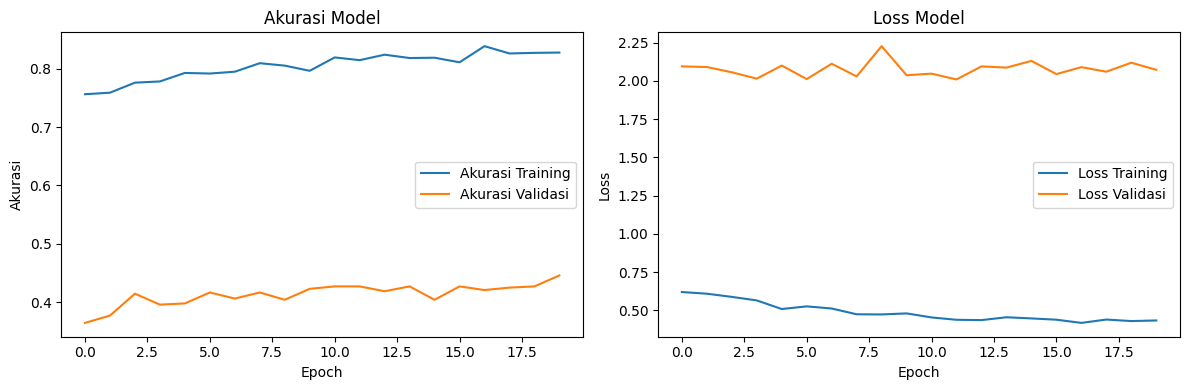

In [13]:
# 10. Visualisasi Training
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Akurasi Training')
    plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
    plt.title('Akurasi Model')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss Training')
    plt.plot(history.history['val_loss'], label='Loss Validasi')
    plt.title('Loss Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_training_history(history_finetune)


Berdasarkan diagram hasil training di atas, saya melihat bahwa akurasi pada data training meningkat secara konsisten hingga mencapai lebih dari 80%, namun akurasi pada data validasi cenderung stagnan di kisaran 40%. Sementara itu, nilai loss pada data training terus menurun, tetapi loss pada data validasi tetap tinggi dan tidak menunjukkan penurunan yang signifikan. Hal ini menunjukkan bahwa model saya mengalami overfitting, di mana model sangat baik dalam mengenali pola pada data training namun kurang mampu melakukan generalisasi pada data baru atau data validasi. Dengan kondisi seperti ini, saya menyadari perlunya penambahan data, augmentasi lebih lanjut, atau penyesuaian parameter agar performa model pada data validasi dapat meningkat dan model menjadi lebih robust.

<h1>Evaluasi Model (Confusion Matrix & Classification Report)</h1>

## Penjelasan Kode Evaluasi Model (Confusion Matrix & Classification Report)

Kode di atas digunakan untuk mengevaluasi performa model klasifikasi kulit wajah pada data validasi. Berikut penjelasan setiap bagian dan manfaatnya:

### 1. **Prediksi dan Label Sebenarnya**
- `y_true = val_gen.classes`  
    Mengambil label asli (ground truth) dari data validasi.
- `y_pred = np.argmax(model.predict(val_gen), axis=1)`  
    Melakukan prediksi pada seluruh data validasi, lalu mengambil indeks kelas dengan probabilitas tertinggi sebagai hasil prediksi.

### 2. **Classification Report**
- `classification_report(y_true, y_pred, target_names=categories)`  
    Menghasilkan laporan metrik evaluasi seperti precision, recall, f1-score, dan support untuk setiap kelas.  
    **Manfaat:**  
    - Mengetahui seberapa baik model dalam mengklasifikasikan setiap kategori kulit.
    - Membantu mengidentifikasi kelas mana yang performanya masih kurang.

### 3. **Confusion Matrix**
- `confusion_matrix(y_true, y_pred)`  
    Membuat matriks yang menunjukkan jumlah prediksi benar dan salah untuk setiap kelas.
- Visualisasi dengan `sns.heatmap`  
    Matriks divisualisasikan agar lebih mudah dianalisis.

    **Manfaat:**  
    - Mengetahui pola kesalahan model, misal kelas mana yang sering tertukar.
    - Membantu dalam perbaikan model atau dataset jika ditemukan bias atau ketidakseimbangan.


8/8 [==============================] - 5s 508ms/step

Classification Report:
              precision    recall  f1-score   support

        Acne       0.64      0.17      0.27        80
  Blackheads       0.45      0.84      0.59        80
  Dark Spots       0.27      0.54      0.36        80
 Normal Skin       0.67      0.25      0.36        80
   Oily Skin       0.24      0.15      0.18        80
    Wrinkles       0.74      0.62      0.68        80

    accuracy                           0.43       480
   macro avg       0.50      0.43      0.41       480
weighted avg       0.50      0.43      0.41       480

Confusion Matrix:


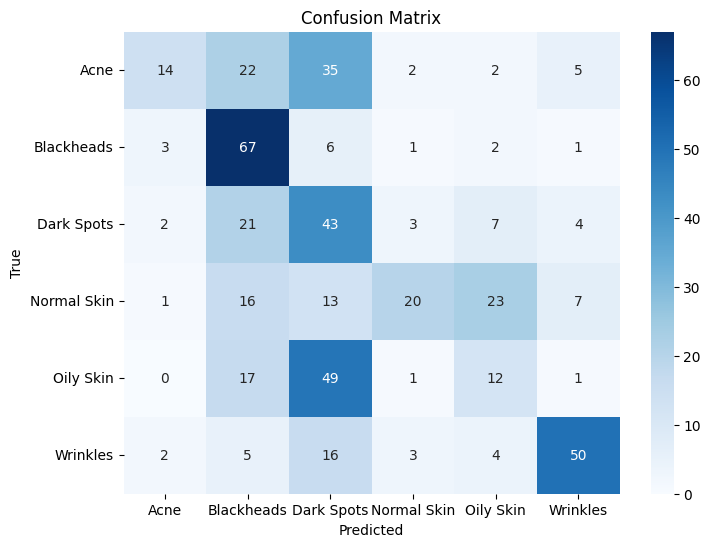

In [14]:
# 11. Evaluasi Model (Confusion Matrix & Classification Report)
y_true = val_gen.classes
y_pred = np.argmax(model.predict(val_gen), axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=categories))

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Berdasarkan classification report dan confusion matrix di atas, saya melihat model saya masih sering salah mengklasifikasikan gambar, terutama pada kelas Acne, Oily Skin, dan Normal Skin, sehingga akurasi keseluruhan hanya sekitar 43%.



<h1>Prediksi Gambar Baru</h1>

Disediakan fungsi untuk memprediksi kelas dari gambar baru:
- Gambar di-preprocess seperti data training.
- Model mengeluarkan prediksi kelas dan confidence score.

1/1 [==============================] - 0s 20ms/step
Predicted class index: 0
Predicted class name: Acne
Confidence: 65.26%


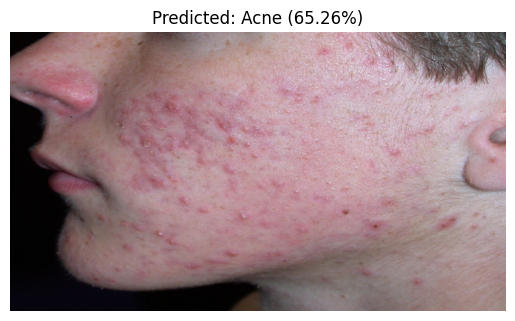


Rekomendasi produk untuk 'Acne':
- COSRX | Acne Pimple Master Patch | Rp59,000
  Link: https://www.sociolla.com/acne-pimple-patch/15018-acne-pimple-master-patch


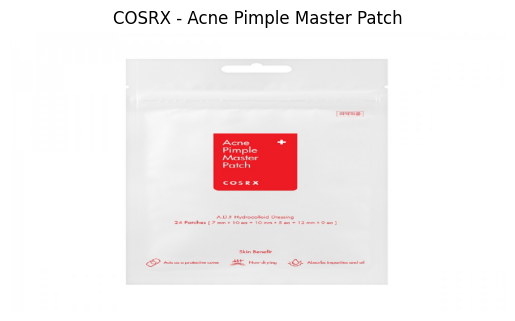

- DERMA ANGEL | Acne Patch Mix 18 | Rp46,000
  Link: https://www.sociolla.com/acne-blemish-treatments/10021-acne-patch-mix-18


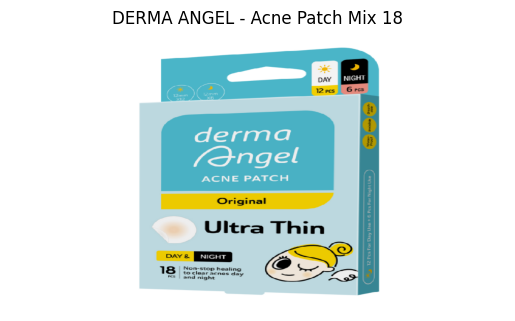

- EMINA | Ms Pimple Acne Solution Spot Gel | Rp37,500
  Link: https://www.sociolla.com/acne-treatment-sealing-gel-cream/10872-ms-pimple-acne-solution-spot-gel


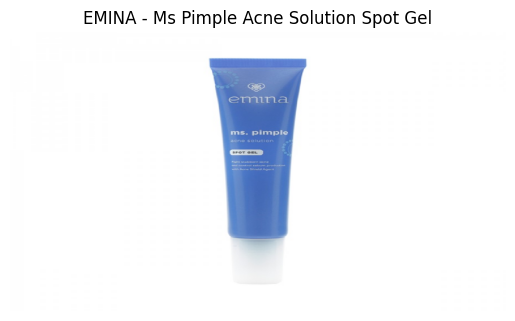

- SKIN1004 | Madagascar Centella Toning Toner | Rp247,000
  Link: https://www.sociolla.com/toner/43308-madagascar-centella-toning-toner?size=30_ml


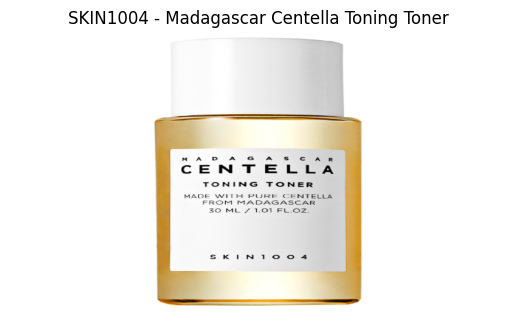

- AVOSKIN | YOUR SKIN BAE SERIES Toner Salicylic Acid 1% + Zinc + Tea Tree Water | Rp165,400
  Link: https://www.sociolla.com/toner/52499-your-skin-bae-series-toner-salicylic-acid-1-zinc-tea-tree-water


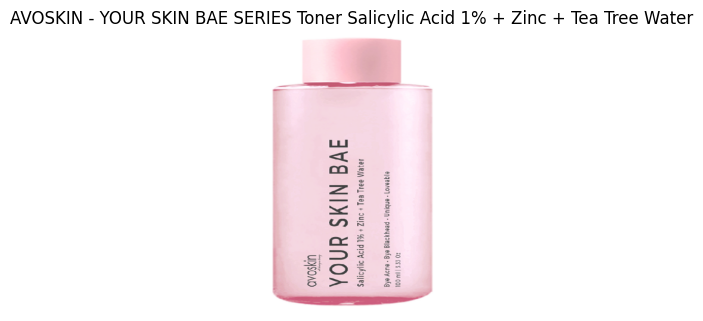

- COSRX | Centella Water Alcohol-Free Toner | Rp215,000
  Link: https://www.sociolla.com/toner/10271-centella-water-alcohol-free-toner


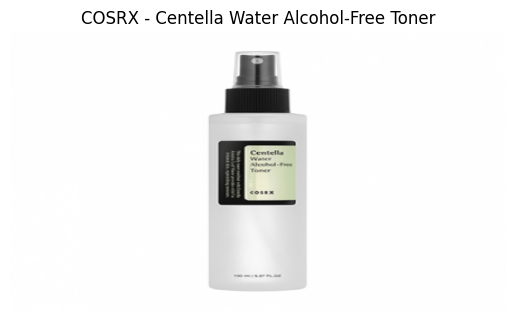

- I'M FROM | Mugwort Essence | Rp149,000
  Link: https://www.sociolla.com/essence/28392-mugwort-essence?size=30_ml


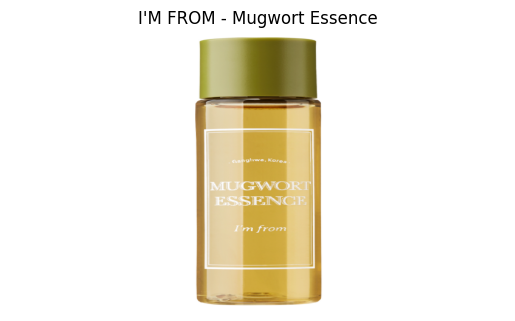

- LACOCO | 5% Bakuchiol Essence | Rp275,500
  Link: https://www.sociolla.com/essence/59572-5-bakuchiol-essence


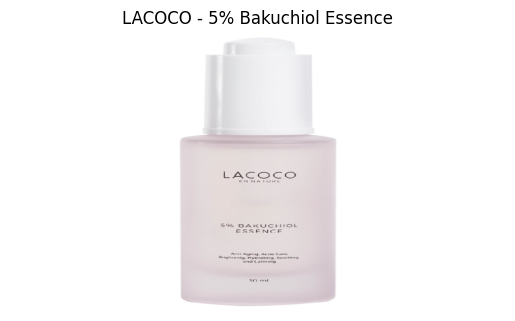

- COSRX | Two in One Poreless Power Liquid | Rp315,000
  Link: https://www.sociolla.com/essence/12514-two-in-one-poreless-power-liquid


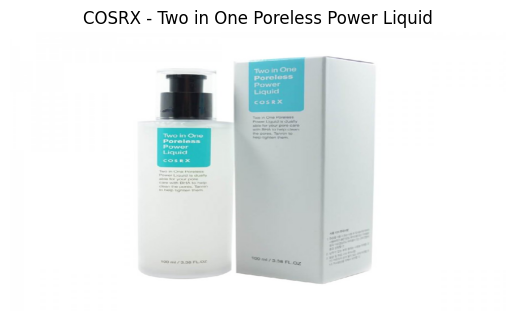

- WHITELAB | Acne Calming Serum | Rp88,500
  Link: https://www.sociolla.com/face-serum/53877-whitelab-acne-calming-serum


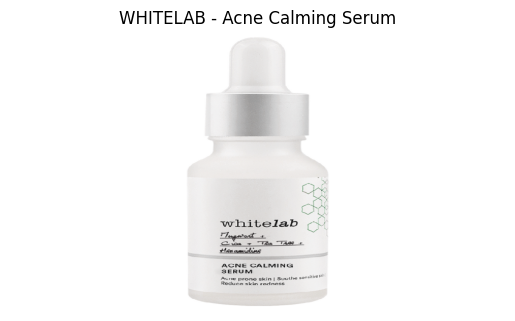

- AVOSKIN | YOUR SKIN BAE SERIES ByeAcne ByeBlackhead Salicylic Acid 2% + Zinc | Rp154,300
  Link: https://www.sociolla.com/face-serum/52502-your-skin-bae-series-byeacne-byeblackhead-salicylic-acid-2-zinc


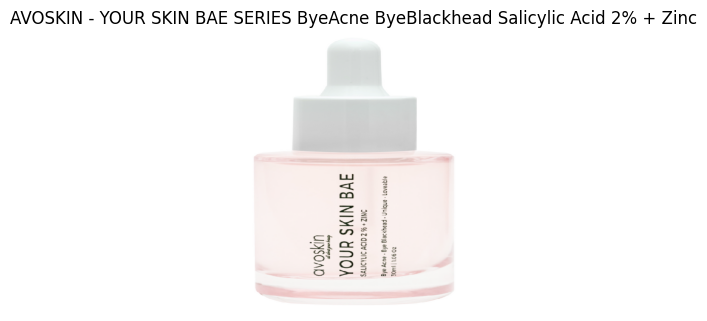

- ROJUKISS | Tea Tree Bija Pro Acne Serum | Rp23,000
  Link: https://www.sociolla.com/face-serum/53764-tea-tree-bija-pro-acne-serum


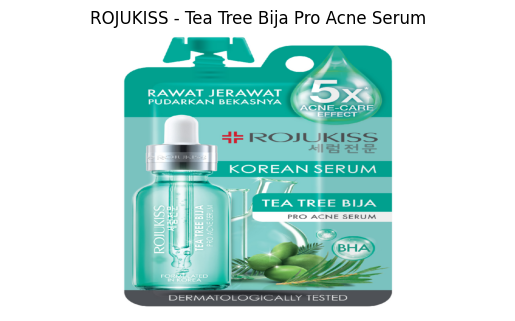

- NPURE | Cica Chocomint Clay Mask | Rp132,090
  Link: https://www.sociolla.com/sheet-mask/53997-cica-chocomint-clay-mask


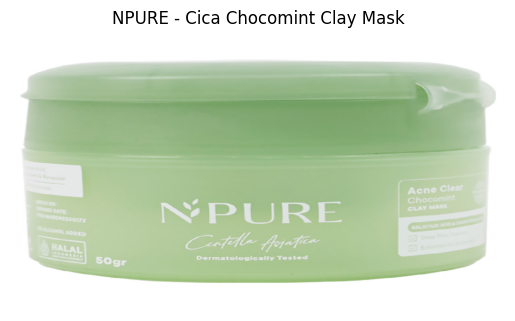

- MEDIHEAL | Teatree Essential Mask | Rp29,900
  Link: https://www.sociolla.com/sheet-mask/9039-teatree-care-solution-essential-mask-ex


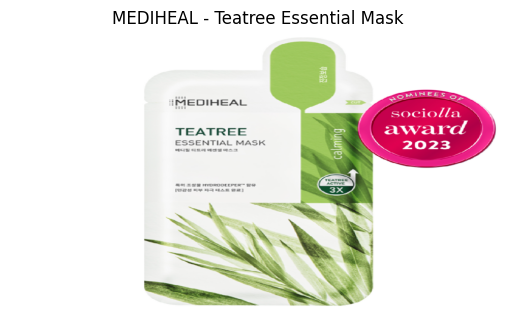

In [34]:
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = tf.expand_dims(img_array, axis=0)
    return img_array

def predict_skin_condition(model, img_path, categories):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = tf.argmax(predictions, axis=1).numpy()[0]
    confidence = float(np.max(predictions)) * 100
    return predicted_class, categories[predicted_class], confidence

def show_recommendations(predicted_label):
    df = pd.read_csv('skincare_product/treatment.csv')
    produk = df[df['Tags'].str.lower() == predicted_label.lower()]
    if produk.empty:
        print("Tidak ada rekomendasi produk untuk kategori ini.")
        return
    print(f"\nRekomendasi produk untuk '{predicted_label}':")
    for _, row in produk.iterrows():
        print(f"- {row['Brand']} | {row['Product Name']} | {row['Price']}")
        print(f"  Link: {row['Links']}")
        # Cek semua kemungkinan ekstensi gambar
        img_found = False
        for ext in ['png', 'jpg', 'jpeg', 'webp']:
            img_path = f"skincare_product/gambar_produk/{row['Id']}.{ext}"
            if os.path.exists(img_path):
                img_prod = image.load_img(img_path, target_size=(720, 1280))
                plt.figure()
                plt.imshow(img_prod)
                plt.title(f"{row['Brand']} - {row['Product Name']}")
                plt.axis('off')
                plt.show()
                img_found = True
                break
        if not img_found:
            # Jika tidak ditemukan, coba cari dengan glob (jaga-jaga ada nama file aneh)
            pattern = f"skincare_product/gambar_produk/{row['Id']}.*"
            matches = glob.glob(pattern)
            if matches:
                img_prod = image.load_img(matches[0], target_size=(720, 1280))
                plt.figure()
                plt.imshow(img_prod)
                plt.title(f"{row['Brand']} - {row['Product Name']}")
                plt.axis('off')
                plt.show()
            else:
                print(f"  Gambar produk tidak ditemukan untuk ID: {row['Id']}")

# Contoh penggunaan prediksi gambar baru
img_path = "acne.jpeg"  # Ganti dengan path gambar yang ingin diuji
if os.path.exists(img_path):
    predicted_class_index, predicted_class_name, confidence = predict_skin_condition(model, img_path, categories)
    print(f"Predicted class index: {predicted_class_index}")
    print(f"Predicted class name: {predicted_class_name}")
    print(f"Confidence: {confidence:.2f}%")
    img_disp = image.load_img(img_path, target_size=(720, 1280))
    plt.imshow(img_disp)
    plt.title(f"Predicted: {predicted_class_name} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()
    show_recommendations(predicted_class_name)
else:
    print(f"File {img_path} tidak ditemukan.")

<h1>Simpan model</h1>

In [17]:
# 13. SIMPAN MODEL
model.save('best_skin_model.h5')

<h1>Ekspor Model ke bentuk ONNX</h1>

In [18]:
#14.EKSPOR MODEL KE ONNX
import tf2onnx
import onnx
model = tf.keras.models.load_model('best_skin_model.h5')
spec = (tf.TensorSpec((None, img_size, img_size, 3), tf.float32, name="input_1"),)
output_path = 'best_skin_model.onnx'
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, output_path=output_path)
onnx.save_model(model_proto, output_path)
print(f"Model berhasil diekspor ke {output_path}")

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
Model berhasil diekspor ke best_skin_model.onnx
